#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets
from torchvision import transforms
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from models import *
from fer import FER2013

#### Setting up CUDA

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Reading the Dataset
Emotions : 0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 4 = Sad, 5 = Surprise, 6 = Neutral

In [9]:
data_example = pd.read_csv("./data/fer2013.csv") 
data_example.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


#### Creating Training and Validation Sets
1. Data is read from the path.
2. The String Based Pixels are converted to an ND Array of image.
3. Validation Split of 20% is set.
4. Data is shuffled.
5. Data is split and corresponding samplers and loaders are made.

In [10]:
class CustomDatasetFromCSV():
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.labels = pd.get_dummies(self.data['emotion']).values
        self.height = 48
        self.width = 48
        self.transform = transform

    def __getitem__(self, index):
        # This method should return only 1 sample and label 
        # (according to "index"), not the whole dataset
        # So probably something like this for you:
        pixel_sequence = self.data['pixels'][index]
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(self.width, self.height)
        face = cv2.resize(face.astype('uint8'), (self.width, self.height))
        label = self.labels[index]

        return face, label
    
    def __len__(self):
        return len(self.labels)


dataset = CustomDatasetFromCSV("./data/fer2013.csv")
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PyTorch data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

#### Sample Images

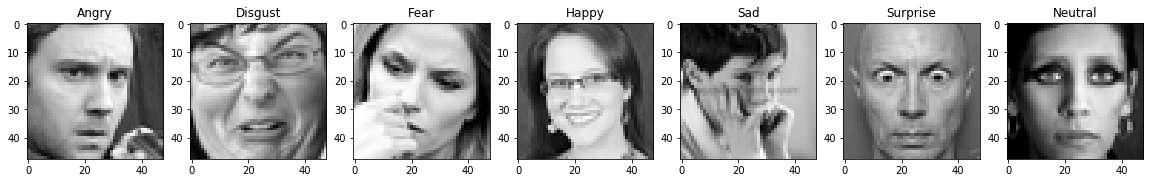

In [11]:
def display_images(img_list, cmap='gray', cols = 7, fig_size = (20,10) ):
    i = 1  # for subplot

    num_images = len(img_list)
    num_rows = num_images / cols

    plt.figure(figsize=fig_size)       

    for image in img_list:
        emotion_type = image[1]
        plt.subplot(num_rows, cols, i)        
        plt.title(emotion_type)
        plt.imshow(image[0], cmap=cmap)        
        i += 1     

    plt.show()
    
sample_images = [[dataset.__getitem__(0)[0],"Angry"],
                 [dataset.__getitem__(299)[0],"Disgust"],
                 [dataset.__getitem__(2)[0],"Fear"],
                 [dataset.__getitem__(7)[0],"Happy"],
                 [dataset.__getitem__(3)[0],"Sad"],
                 [dataset.__getitem__(15)[0],"Surprise"],
                 [dataset.__getitem__(4)[0],"Neutral"]]

display_images(sample_images)

#### Image Transforms

In [6]:
cut_size = 44

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

#### Loading the trained model and splitting the dataset

In [7]:
net = VGG('VGG19')
path = 'FER2013_VGG19'
checkpoint = torch.load('./FER2013_VGG19/PrivateTest_model.t7')
net.load_state_dict(checkpoint['net'])
net.cuda()
net.eval()

Testset = FER2013(split = 'PrivateTest', transform=transform_test)
Testloader = torch.utils.data.DataLoader(Testset, batch_size=2, shuffle=False, num_workers=1)

#### Testing

In [8]:
correct = 0
total = 0
all_target = []

for batch_idx, (inputs, targets) in enumerate(Testloader):

    bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=True), Variable(targets)
    outputs = net(inputs)

    outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
    _, predicted = torch.max(outputs_avg.data, 1)

    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
    if batch_idx == 0:
        all_predicted = predicted
        all_targets = targets
    else:
        all_predicted = torch.cat((all_predicted, predicted),0)
        all_targets = torch.cat((all_targets, targets),0)

acc = 100. * correct / total
print("accuracy: %0.3f" % acc)

/home/aniruddha/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


accuracy: 72.000
